In [1]:
import os
from importlib.resources import files

import copy
import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry, LinearField
from learn_embedding.utils import *
from learn_embedding.loss import *

## Load Dataset

In [2]:
dim = 2
num_traj = 3  # Number of trajectories
num_samples = 1000  # Desired number of samples per trajectory

train_x = np.empty((0, 4))
train_y = np.empty((0, 2))

for i in range(1, num_traj + 1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    
    # remove last point
    data = data[:-1,:]
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    data[idx,:2] -= data[-1,:2]
    
    # zero velocity last sample
    data[-1,2:4] = np.zeros(2)
    
    # zero acceleration last sample
    data[-1,-2:] = np.zeros(2)
    
    # add to datset
    train_x = np.append(train_x, data[idx,:4], axis=0)
    train_y = np.append(train_y, data[idx,-2:], axis=0)

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)

## Create Model

In [4]:
# model_first = FirstGeometry(Embedding(FeedForward(dim, [64]*2, 1)), 
#                       torch.tensor([0.0,0.0]).to(device), 
#                       SPD(dim)).to(device)
# TorchHelper.load(model_first,'../outputs/Khamesh_1')

In [5]:
# torch.manual_seed(1337)

# approximator = KernelExpansion(train_x[:, :dim])
# approximator = KernelMachine(dim, 1000, 1, length=0.4)

num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

# embedding = copy.deepcopy(model_first.embedding)
# TorchHelper.set_grad(embedding, False)
embedding = Embedding(approximator)

# stiffness = copy.deepcopy(model_first.stiffness)
# dissipation = copy.deepcopy(model_first.stiffness)
# dissipation.eigval = 2*dissipation.eigval
stiffness = Spherical(eval=1,grad=True)
dissipation = Spherical(eval=2,grad=True)
# stiffness = SPD(dim)
# dissipation = SPD(dim)

attractor = train_x[-1][:2].detach()

field = LinearField(attractor, Spherical(1.0, True))
field_weight = 1.0

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)
# TorchHelper.load(model, '../outputs/' + dataset + '_2')
# model.velocity_embedding = False
# TorchHelper.set_grad(model_first, False)

## Train

In [6]:
trainer = Trainer(model, train_x, train_y)

trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
# trainer.optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=1e-1)

trainer.loss = torch.nn.MSELoss()
# trainer.loss = torch.nn.SmoothL1Loss()
# trainer.loss = WeighedMagnitudeDirectionLoss(magnitude_weight=0.0, direction_weight=1.0)

trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=5000, record_loss=True)

loss = trainer.train()
# TorchHelper.save(model, '../outputs/' + dataset + '_2')

EPOCH:  0 ITER:  0 LR:  0.01 LOSS:  0.046472206711769104
EPOCH:  1 ITER:  0 LR:  0.01 LOSS:  0.01728355698287487
EPOCH:  2 ITER:  0 LR:  0.01 LOSS:  0.009948627091944218
EPOCH:  3 ITER:  0 LR:  0.01 LOSS:  0.008911550976336002
EPOCH:  4 ITER:  0 LR:  0.01 LOSS:  0.00873305182904005
EPOCH:  5 ITER:  0 LR:  0.01 LOSS:  0.00862053781747818
EPOCH:  6 ITER:  0 LR:  0.01 LOSS:  0.008505526930093765
EPOCH:  7 ITER:  0 LR:  0.01 LOSS:  0.008417638018727303
EPOCH:  8 ITER:  0 LR:  0.01 LOSS:  0.00834728591144085
EPOCH:  9 ITER:  0 LR:  0.01 LOSS:  0.008269920945167542
EPOCH:  10 ITER:  0 LR:  0.01 LOSS:  0.00818040780723095
EPOCH:  11 ITER:  0 LR:  0.01 LOSS:  0.008090149611234665
EPOCH:  12 ITER:  0 LR:  0.01 LOSS:  0.00801143143326044
EPOCH:  13 ITER:  0 LR:  0.01 LOSS:  0.007948186248540878
EPOCH:  14 ITER:  0 LR:  0.01 LOSS:  0.007896150462329388
EPOCH:  15 ITER:  0 LR:  0.01 LOSS:  0.007849270477890968
EPOCH:  16 ITER:  0 LR:  0.01 LOSS:  0.007805675268173218
EPOCH:  17 ITER:  0 LR:  0.01 

EPOCH:  144 ITER:  0 LR:  0.01 LOSS:  0.00630353856831789
EPOCH:  145 ITER:  0 LR:  0.01 LOSS:  0.006297670304775238
EPOCH:  146 ITER:  0 LR:  0.01 LOSS:  0.006291871424764395
EPOCH:  147 ITER:  0 LR:  0.01 LOSS:  0.0062861996702849865
EPOCH:  148 ITER:  0 LR:  0.01 LOSS:  0.00628015398979187
EPOCH:  149 ITER:  0 LR:  0.01 LOSS:  0.0062745604664087296
EPOCH:  150 ITER:  0 LR:  0.01 LOSS:  0.0062691145576536655
EPOCH:  151 ITER:  0 LR:  0.01 LOSS:  0.006263543386012316
EPOCH:  152 ITER:  0 LR:  0.01 LOSS:  0.0062574404291808605
EPOCH:  153 ITER:  0 LR:  0.01 LOSS:  0.006250925827771425
EPOCH:  154 ITER:  0 LR:  0.01 LOSS:  0.006244509480893612
EPOCH:  155 ITER:  0 LR:  0.01 LOSS:  0.00623819837346673
EPOCH:  156 ITER:  0 LR:  0.01 LOSS:  0.0062315152026712894
EPOCH:  157 ITER:  0 LR:  0.01 LOSS:  0.006224060896784067
EPOCH:  158 ITER:  0 LR:  0.01 LOSS:  0.006216130219399929
EPOCH:  159 ITER:  0 LR:  0.01 LOSS:  0.00620819628238678
EPOCH:  160 ITER:  0 LR:  0.01 LOSS:  0.006199849769473

EPOCH:  283 ITER:  0 LR:  0.01 LOSS:  0.003748906310647726
EPOCH:  284 ITER:  0 LR:  0.01 LOSS:  0.003397786756977439
EPOCH:  285 ITER:  0 LR:  0.01 LOSS:  0.003397317137569189
EPOCH:  286 ITER:  0 LR:  0.01 LOSS:  0.0035909416619688272
EPOCH:  287 ITER:  0 LR:  0.01 LOSS:  0.00334152695722878
EPOCH:  288 ITER:  0 LR:  0.01 LOSS:  0.003314044326543808
EPOCH:  289 ITER:  0 LR:  0.01 LOSS:  0.003470680443570018
EPOCH:  290 ITER:  0 LR:  0.01 LOSS:  0.003357573412358761
EPOCH:  291 ITER:  0 LR:  0.01 LOSS:  0.003267891239374876
EPOCH:  292 ITER:  0 LR:  0.01 LOSS:  0.003252713941037655
EPOCH:  293 ITER:  0 LR:  0.01 LOSS:  0.003306743921712041
EPOCH:  294 ITER:  0 LR:  0.01 LOSS:  0.0033620805479586124
EPOCH:  295 ITER:  0 LR:  0.01 LOSS:  0.003227529814466834
EPOCH:  296 ITER:  0 LR:  0.01 LOSS:  0.0031995249446481466
EPOCH:  297 ITER:  0 LR:  0.01 LOSS:  0.0032520731911063194
EPOCH:  298 ITER:  0 LR:  0.01 LOSS:  0.003235163167119026
EPOCH:  299 ITER:  0 LR:  0.01 LOSS:  0.0032155576627

EPOCH:  430 ITER:  0 LR:  0.01 LOSS:  0.0026862516533583403
EPOCH:  431 ITER:  0 LR:  0.01 LOSS:  0.002694076858460903
EPOCH:  432 ITER:  0 LR:  0.01 LOSS:  0.0027010745834559202
EPOCH:  433 ITER:  0 LR:  0.01 LOSS:  0.002716830000281334
EPOCH:  434 ITER:  0 LR:  0.01 LOSS:  0.0027216929011046886
EPOCH:  435 ITER:  0 LR:  0.01 LOSS:  0.0027442965656518936
EPOCH:  436 ITER:  0 LR:  0.01 LOSS:  0.002742422977462411
EPOCH:  437 ITER:  0 LR:  0.01 LOSS:  0.0027693898882716894
EPOCH:  438 ITER:  0 LR:  0.01 LOSS:  0.0027531536761671305
EPOCH:  439 ITER:  0 LR:  0.01 LOSS:  0.0027677014004439116
EPOCH:  440 ITER:  0 LR:  0.01 LOSS:  0.0027308331336826086
EPOCH:  441 ITER:  0 LR:  0.01 LOSS:  0.0027127049397677183
EPOCH:  442 ITER:  0 LR:  0.01 LOSS:  0.002681039273738861
EPOCH:  443 ITER:  0 LR:  0.01 LOSS:  0.0026641536969691515
EPOCH:  444 ITER:  0 LR:  0.01 LOSS:  0.002657641191035509
EPOCH:  445 ITER:  0 LR:  0.01 LOSS:  0.002659959951415658
EPOCH:  446 ITER:  0 LR:  0.01 LOSS:  0.002669

EPOCH:  569 ITER:  0 LR:  0.01 LOSS:  0.002397621050477028
EPOCH:  570 ITER:  0 LR:  0.01 LOSS:  0.0023940913379192352
EPOCH:  571 ITER:  0 LR:  0.01 LOSS:  0.002391453366726637
EPOCH:  572 ITER:  0 LR:  0.01 LOSS:  0.002388903172686696
EPOCH:  573 ITER:  0 LR:  0.01 LOSS:  0.002388386055827141
EPOCH:  574 ITER:  0 LR:  0.01 LOSS:  0.002388289198279381
EPOCH:  575 ITER:  0 LR:  0.01 LOSS:  0.0023936370853334665
EPOCH:  576 ITER:  0 LR:  0.01 LOSS:  0.0023998357355594635
EPOCH:  577 ITER:  0 LR:  0.01 LOSS:  0.0024216140154749155
EPOCH:  578 ITER:  0 LR:  0.01 LOSS:  0.0024379671085625887
EPOCH:  579 ITER:  0 LR:  0.01 LOSS:  0.002489660866558552
EPOCH:  580 ITER:  0 LR:  0.01 LOSS:  0.0024896012619137764
EPOCH:  581 ITER:  0 LR:  0.01 LOSS:  0.002523308154195547
EPOCH:  582 ITER:  0 LR:  0.01 LOSS:  0.0024457150138914585
EPOCH:  583 ITER:  0 LR:  0.01 LOSS:  0.0023857865016907454
EPOCH:  584 ITER:  0 LR:  0.01 LOSS:  0.0023362678475677967
EPOCH:  585 ITER:  0 LR:  0.01 LOSS:  0.0023385

EPOCH:  708 ITER:  0 LR:  0.01 LOSS:  0.0019383948529139161
EPOCH:  709 ITER:  0 LR:  0.01 LOSS:  0.0019377099815756083
EPOCH:  710 ITER:  0 LR:  0.01 LOSS:  0.0019368414068594575
EPOCH:  711 ITER:  0 LR:  0.01 LOSS:  0.0019360006554052234
EPOCH:  712 ITER:  0 LR:  0.01 LOSS:  0.001934993197210133
EPOCH:  713 ITER:  0 LR:  0.01 LOSS:  0.0019354294054210186
EPOCH:  714 ITER:  0 LR:  0.01 LOSS:  0.0019376198761165142
EPOCH:  715 ITER:  0 LR:  0.01 LOSS:  0.0019455075962468982
EPOCH:  716 ITER:  0 LR:  0.01 LOSS:  0.0019605252891778946
EPOCH:  717 ITER:  0 LR:  0.01 LOSS:  0.001997991930693388
EPOCH:  718 ITER:  0 LR:  0.01 LOSS:  0.0020493827760219574
EPOCH:  719 ITER:  0 LR:  0.01 LOSS:  0.0021451138891279697
EPOCH:  720 ITER:  0 LR:  0.01 LOSS:  0.0021601426415145397
EPOCH:  721 ITER:  0 LR:  0.01 LOSS:  0.0021392437629401684
EPOCH:  722 ITER:  0 LR:  0.01 LOSS:  0.0020008801948279142
EPOCH:  723 ITER:  0 LR:  0.01 LOSS:  0.0019487797981128097
EPOCH:  724 ITER:  0 LR:  0.01 LOSS:  0.00

EPOCH:  852 ITER:  0 LR:  0.01 LOSS:  0.0017787213437259197
EPOCH:  853 ITER:  0 LR:  0.01 LOSS:  0.0017782580107450485
EPOCH:  854 ITER:  0 LR:  0.01 LOSS:  0.0017834913451224566
EPOCH:  855 ITER:  0 LR:  0.01 LOSS:  0.0017981302225962281
EPOCH:  856 ITER:  0 LR:  0.01 LOSS:  0.0018116449937224388
EPOCH:  857 ITER:  0 LR:  0.01 LOSS:  0.0018321906682103872
EPOCH:  858 ITER:  0 LR:  0.01 LOSS:  0.0018382975831627846
EPOCH:  859 ITER:  0 LR:  0.01 LOSS:  0.0018312693573534489
EPOCH:  860 ITER:  0 LR:  0.01 LOSS:  0.0018015706446021795
EPOCH:  861 ITER:  0 LR:  0.01 LOSS:  0.00178246118593961
EPOCH:  862 ITER:  0 LR:  0.01 LOSS:  0.001775837503373623
EPOCH:  863 ITER:  0 LR:  0.01 LOSS:  0.001780051621608436
EPOCH:  864 ITER:  0 LR:  0.01 LOSS:  0.00177988619543612
EPOCH:  865 ITER:  0 LR:  0.01 LOSS:  0.001773786498233676
EPOCH:  866 ITER:  0 LR:  0.01 LOSS:  0.0017734197899699211
EPOCH:  867 ITER:  0 LR:  0.01 LOSS:  0.0017804920207709074
EPOCH:  868 ITER:  0 LR:  0.01 LOSS:  0.0017993

EPOCH:  999 ITER:  0 LR:  0.01 LOSS:  0.0018821352859959006
EPOCH:  1000 ITER:  0 LR:  0.01 LOSS:  0.0018310145242139697
EPOCH:  1001 ITER:  0 LR:  0.01 LOSS:  0.0018059680005535483
EPOCH:  1002 ITER:  0 LR:  0.01 LOSS:  0.0016755856340751052
EPOCH:  1003 ITER:  0 LR:  0.01 LOSS:  0.0016454154392704368
EPOCH:  1004 ITER:  0 LR:  0.01 LOSS:  0.001709858188405633
EPOCH:  1005 ITER:  0 LR:  0.01 LOSS:  0.0017744130454957485
EPOCH:  1006 ITER:  0 LR:  0.01 LOSS:  0.0019021069165319204
EPOCH:  1007 ITER:  0 LR:  0.01 LOSS:  0.001751040923409164
EPOCH:  1008 ITER:  0 LR:  0.01 LOSS:  0.0016642118571326137
EPOCH:  1009 ITER:  0 LR:  0.01 LOSS:  0.0016422634944319725
EPOCH:  1010 ITER:  0 LR:  0.01 LOSS:  0.001696453895419836
EPOCH:  1011 ITER:  0 LR:  0.01 LOSS:  0.001793342875316739
EPOCH:  1012 ITER:  0 LR:  0.01 LOSS:  0.0017769435653463006
EPOCH:  1013 ITER:  0 LR:  0.01 LOSS:  0.0017881487729027867
EPOCH:  1014 ITER:  0 LR:  0.01 LOSS:  0.0016685540322214365
EPOCH:  1015 ITER:  0 LR:  0.

EPOCH:  1139 ITER:  0 LR:  0.01 LOSS:  0.0015917060663923621
EPOCH:  1140 ITER:  0 LR:  0.01 LOSS:  0.001590800122357905
EPOCH:  1141 ITER:  0 LR:  0.01 LOSS:  0.001589560299180448
EPOCH:  1142 ITER:  0 LR:  0.01 LOSS:  0.0015888325870037079
EPOCH:  1143 ITER:  0 LR:  0.01 LOSS:  0.0015882864827290177
EPOCH:  1144 ITER:  0 LR:  0.01 LOSS:  0.0015871808864176273
EPOCH:  1145 ITER:  0 LR:  0.01 LOSS:  0.001586244790814817
EPOCH:  1146 ITER:  0 LR:  0.01 LOSS:  0.0015857269754633307
EPOCH:  1147 ITER:  0 LR:  0.01 LOSS:  0.0015849685296416283
EPOCH:  1148 ITER:  0 LR:  0.01 LOSS:  0.0015837913379073143
EPOCH:  1149 ITER:  0 LR:  0.01 LOSS:  0.0015832330100238323
EPOCH:  1150 ITER:  0 LR:  0.01 LOSS:  0.0015825621085241437
EPOCH:  1151 ITER:  0 LR:  0.01 LOSS:  0.0015817342791706324
EPOCH:  1152 ITER:  0 LR:  0.01 LOSS:  0.0015808108728379011
EPOCH:  1153 ITER:  0 LR:  0.01 LOSS:  0.0015802273992449045
EPOCH:  1154 ITER:  0 LR:  0.01 LOSS:  0.0015795384533703327
EPOCH:  1155 ITER:  0 LR:  

EPOCH:  1277 ITER:  0 LR:  0.01 LOSS:  0.0015624819789081812
EPOCH:  1278 ITER:  0 LR:  0.01 LOSS:  0.0015888363122940063
EPOCH:  1279 ITER:  0 LR:  0.01 LOSS:  0.0015890965005382895
EPOCH:  1280 ITER:  0 LR:  0.01 LOSS:  0.001624472439289093
EPOCH:  1281 ITER:  0 LR:  0.01 LOSS:  0.0015764290001243353
EPOCH:  1282 ITER:  0 LR:  0.01 LOSS:  0.0015582914929836988
EPOCH:  1283 ITER:  0 LR:  0.01 LOSS:  0.001539472839795053
EPOCH:  1284 ITER:  0 LR:  0.01 LOSS:  0.001534643117338419
EPOCH:  1285 ITER:  0 LR:  0.01 LOSS:  0.0015368507010862231
EPOCH:  1286 ITER:  0 LR:  0.01 LOSS:  0.0015447139739990234
EPOCH:  1287 ITER:  0 LR:  0.01 LOSS:  0.0015660860808566213
EPOCH:  1288 ITER:  0 LR:  0.01 LOSS:  0.0015874967211857438
EPOCH:  1289 ITER:  0 LR:  0.01 LOSS:  0.0016486344393342733
EPOCH:  1290 ITER:  0 LR:  0.01 LOSS:  0.0016162715619429946
EPOCH:  1291 ITER:  0 LR:  0.01 LOSS:  0.001639851601794362
EPOCH:  1292 ITER:  0 LR:  0.01 LOSS:  0.0015790743054822087
EPOCH:  1293 ITER:  0 LR:  0

EPOCH:  1416 ITER:  0 LR:  0.01 LOSS:  0.0015141821932047606
EPOCH:  1417 ITER:  0 LR:  0.01 LOSS:  0.0015365686267614365
EPOCH:  1418 ITER:  0 LR:  0.01 LOSS:  0.001550212036818266
EPOCH:  1419 ITER:  0 LR:  0.01 LOSS:  0.0016008155653253198
EPOCH:  1420 ITER:  0 LR:  0.01 LOSS:  0.0015617228345945477
EPOCH:  1421 ITER:  0 LR:  0.01 LOSS:  0.0015497624408453703
EPOCH:  1422 ITER:  0 LR:  0.01 LOSS:  0.00151621806435287
EPOCH:  1423 ITER:  0 LR:  0.01 LOSS:  0.0015020713908597827
EPOCH:  1424 ITER:  0 LR:  0.01 LOSS:  0.001496833865530789
EPOCH:  1425 ITER:  0 LR:  0.01 LOSS:  0.00149989512283355
EPOCH:  1426 ITER:  0 LR:  0.01 LOSS:  0.001509977737441659
EPOCH:  1427 ITER:  0 LR:  0.01 LOSS:  0.0015247511910274625
EPOCH:  1428 ITER:  0 LR:  0.01 LOSS:  0.0015690403524786234
EPOCH:  1429 ITER:  0 LR:  0.01 LOSS:  0.0015817341627553105
EPOCH:  1430 ITER:  0 LR:  0.01 LOSS:  0.0016863574273884296
EPOCH:  1431 ITER:  0 LR:  0.01 LOSS:  0.0015920134028419852
EPOCH:  1432 ITER:  0 LR:  0.01

EPOCH:  1558 ITER:  0 LR:  0.01 LOSS:  0.001510606613010168
EPOCH:  1559 ITER:  0 LR:  0.01 LOSS:  0.0015482294838875532
EPOCH:  1560 ITER:  0 LR:  0.01 LOSS:  0.001527040614746511
EPOCH:  1561 ITER:  0 LR:  0.01 LOSS:  0.0015420950949192047
EPOCH:  1562 ITER:  0 LR:  0.01 LOSS:  0.0015131602995097637
EPOCH:  1563 ITER:  0 LR:  0.01 LOSS:  0.0015107233775779605
EPOCH:  1564 ITER:  0 LR:  0.01 LOSS:  0.0014983927831053734
EPOCH:  1565 ITER:  0 LR:  0.01 LOSS:  0.001483291620388627
EPOCH:  1566 ITER:  0 LR:  0.01 LOSS:  0.0014845000114291906
EPOCH:  1567 ITER:  0 LR:  0.01 LOSS:  0.0014867271529510617
EPOCH:  1568 ITER:  0 LR:  0.01 LOSS:  0.0015029310015961528
EPOCH:  1569 ITER:  0 LR:  0.01 LOSS:  0.0015024917665868998
EPOCH:  1570 ITER:  0 LR:  0.01 LOSS:  0.0015046104090288281
EPOCH:  1571 ITER:  0 LR:  0.01 LOSS:  0.001482482417486608
EPOCH:  1572 ITER:  0 LR:  0.01 LOSS:  0.0014690941898152232
EPOCH:  1573 ITER:  0 LR:  0.01 LOSS:  0.0014737891033291817
EPOCH:  1574 ITER:  0 LR:  0

EPOCH:  1696 ITER:  0 LR:  0.01 LOSS:  0.001451984397135675
EPOCH:  1697 ITER:  0 LR:  0.01 LOSS:  0.0014527540188282728
EPOCH:  1698 ITER:  0 LR:  0.01 LOSS:  0.0014516661176458001
EPOCH:  1699 ITER:  0 LR:  0.01 LOSS:  0.0014506260631605983
EPOCH:  1700 ITER:  0 LR:  0.01 LOSS:  0.0014513799687847495
EPOCH:  1701 ITER:  0 LR:  0.01 LOSS:  0.0014496427029371262
EPOCH:  1702 ITER:  0 LR:  0.01 LOSS:  0.0014491339679807425
EPOCH:  1703 ITER:  0 LR:  0.01 LOSS:  0.001449408009648323
EPOCH:  1704 ITER:  0 LR:  0.01 LOSS:  0.0014481658581644297
EPOCH:  1705 ITER:  0 LR:  0.01 LOSS:  0.0014480120735242963
EPOCH:  1706 ITER:  0 LR:  0.01 LOSS:  0.0014476703945547342
EPOCH:  1707 ITER:  0 LR:  0.01 LOSS:  0.0014465650310739875
EPOCH:  1708 ITER:  0 LR:  0.01 LOSS:  0.0014466572320088744
EPOCH:  1709 ITER:  0 LR:  0.01 LOSS:  0.0014461575774475932
EPOCH:  1710 ITER:  0 LR:  0.01 LOSS:  0.0014454626943916082
EPOCH:  1711 ITER:  0 LR:  0.01 LOSS:  0.001445283880457282
EPOCH:  1712 ITER:  0 LR:  

EPOCH:  1837 ITER:  0 LR:  0.01 LOSS:  0.001760534243658185
EPOCH:  1838 ITER:  0 LR:  0.01 LOSS:  0.0018379987450316548
EPOCH:  1839 ITER:  0 LR:  0.01 LOSS:  0.0016601033275946975
EPOCH:  1840 ITER:  0 LR:  0.01 LOSS:  0.0017606382025405765
EPOCH:  1841 ITER:  0 LR:  0.01 LOSS:  0.0017741679912433028
EPOCH:  1842 ITER:  0 LR:  0.01 LOSS:  0.0015964320627972484
EPOCH:  1843 ITER:  0 LR:  0.01 LOSS:  0.0018213022267445922
EPOCH:  1844 ITER:  0 LR:  0.01 LOSS:  0.0014956773957237601
EPOCH:  1845 ITER:  0 LR:  0.01 LOSS:  0.0017245071940124035
EPOCH:  1846 ITER:  0 LR:  0.01 LOSS:  0.0015268363058567047
EPOCH:  1847 ITER:  0 LR:  0.01 LOSS:  0.001613232889212668
EPOCH:  1848 ITER:  0 LR:  0.01 LOSS:  0.0015883689047768712
EPOCH:  1849 ITER:  0 LR:  0.01 LOSS:  0.0015339471865445375
EPOCH:  1850 ITER:  0 LR:  0.01 LOSS:  0.0016251382185146213
EPOCH:  1851 ITER:  0 LR:  0.01 LOSS:  0.001491832546889782
EPOCH:  1852 ITER:  0 LR:  0.01 LOSS:  0.0015704082325100899
EPOCH:  1853 ITER:  0 LR:  

EPOCH:  1976 ITER:  0 LR:  0.01 LOSS:  0.0013999409275129437
EPOCH:  1977 ITER:  0 LR:  0.01 LOSS:  0.0013996487250551581
EPOCH:  1978 ITER:  0 LR:  0.01 LOSS:  0.001399358967319131
EPOCH:  1979 ITER:  0 LR:  0.01 LOSS:  0.0013990738661959767
EPOCH:  1980 ITER:  0 LR:  0.01 LOSS:  0.0013987977290526032
EPOCH:  1981 ITER:  0 LR:  0.01 LOSS:  0.0013985363766551018
EPOCH:  1982 ITER:  0 LR:  0.01 LOSS:  0.001398312277160585
EPOCH:  1983 ITER:  0 LR:  0.01 LOSS:  0.0013981688534840941
EPOCH:  1984 ITER:  0 LR:  0.01 LOSS:  0.0013982343953102827
EPOCH:  1985 ITER:  0 LR:  0.01 LOSS:  0.0013987204292789102
EPOCH:  1986 ITER:  0 LR:  0.01 LOSS:  0.0014005372067913413
EPOCH:  1987 ITER:  0 LR:  0.01 LOSS:  0.0014044849667698145
EPOCH:  1988 ITER:  0 LR:  0.01 LOSS:  0.0014177256962284446
EPOCH:  1989 ITER:  0 LR:  0.01 LOSS:  0.0014370656572282314
EPOCH:  1990 ITER:  0 LR:  0.01 LOSS:  0.001517613884061575
EPOCH:  1991 ITER:  0 LR:  0.01 LOSS:  0.0015219941269606352
EPOCH:  1992 ITER:  0 LR:  

EPOCH:  2118 ITER:  0 LR:  0.01 LOSS:  0.0013879621401429176
EPOCH:  2119 ITER:  0 LR:  0.01 LOSS:  0.0013875776203349233
EPOCH:  2120 ITER:  0 LR:  0.01 LOSS:  0.0013872302370145917
EPOCH:  2121 ITER:  0 LR:  0.01 LOSS:  0.001386828487738967
EPOCH:  2122 ITER:  0 LR:  0.01 LOSS:  0.0013864848297089338
EPOCH:  2123 ITER:  0 LR:  0.01 LOSS:  0.0013860923936590552
EPOCH:  2124 ITER:  0 LR:  0.01 LOSS:  0.0013857592130079865
EPOCH:  2125 ITER:  0 LR:  0.01 LOSS:  0.0013853884302079678
EPOCH:  2126 ITER:  0 LR:  0.01 LOSS:  0.0013850387185811996
EPOCH:  2127 ITER:  0 LR:  0.01 LOSS:  0.0013846828369423747
EPOCH:  2128 ITER:  0 LR:  0.01 LOSS:  0.0013843371998518705
EPOCH:  2129 ITER:  0 LR:  0.01 LOSS:  0.0013839839957654476
EPOCH:  2130 ITER:  0 LR:  0.01 LOSS:  0.001383658149279654
EPOCH:  2131 ITER:  0 LR:  0.01 LOSS:  0.0013833008706569672
EPOCH:  2132 ITER:  0 LR:  0.01 LOSS:  0.0013829682720825076
EPOCH:  2133 ITER:  0 LR:  0.01 LOSS:  0.0013826332287862897
EPOCH:  2134 ITER:  0 LR: 

EPOCH:  2256 ITER:  0 LR:  0.01 LOSS:  0.001468322821892798
EPOCH:  2257 ITER:  0 LR:  0.01 LOSS:  0.0014527963940054178
EPOCH:  2258 ITER:  0 LR:  0.01 LOSS:  0.0014477211516350508
EPOCH:  2259 ITER:  0 LR:  0.01 LOSS:  0.0014561187708750367
EPOCH:  2260 ITER:  0 LR:  0.01 LOSS:  0.0014440587256103754
EPOCH:  2261 ITER:  0 LR:  0.01 LOSS:  0.0014458984369412065
EPOCH:  2262 ITER:  0 LR:  0.01 LOSS:  0.00144038419239223
EPOCH:  2263 ITER:  0 LR:  0.01 LOSS:  0.0014394317986443639
EPOCH:  2264 ITER:  0 LR:  0.01 LOSS:  0.0014316862216219306
EPOCH:  2265 ITER:  0 LR:  0.01 LOSS:  0.0014339662156999111
EPOCH:  2266 ITER:  0 LR:  0.01 LOSS:  0.0014277762966230512
EPOCH:  2267 ITER:  0 LR:  0.01 LOSS:  0.0014278116868808866
EPOCH:  2268 ITER:  0 LR:  0.01 LOSS:  0.0014241954777389765
EPOCH:  2269 ITER:  0 LR:  0.01 LOSS:  0.0014212734531611204
EPOCH:  2270 ITER:  0 LR:  0.01 LOSS:  0.001422631205059588
EPOCH:  2271 ITER:  0 LR:  0.01 LOSS:  0.0014192467788234353
EPOCH:  2272 ITER:  0 LR:  0

EPOCH:  2393 ITER:  0 LR:  0.01 LOSS:  0.001473992713727057
EPOCH:  2394 ITER:  0 LR:  0.01 LOSS:  0.0015587372472509742
EPOCH:  2395 ITER:  0 LR:  0.01 LOSS:  0.0014047634322196245
EPOCH:  2396 ITER:  0 LR:  0.01 LOSS:  0.0013521239161491394
EPOCH:  2397 ITER:  0 LR:  0.01 LOSS:  0.0013909050030633807
EPOCH:  2398 ITER:  0 LR:  0.01 LOSS:  0.0014498871751129627
EPOCH:  2399 ITER:  0 LR:  0.01 LOSS:  0.001577074988745153
EPOCH:  2400 ITER:  0 LR:  0.01 LOSS:  0.0014081342378631234
EPOCH:  2401 ITER:  0 LR:  0.01 LOSS:  0.001351737417280674
EPOCH:  2402 ITER:  0 LR:  0.01 LOSS:  0.0013934284215793014
EPOCH:  2403 ITER:  0 LR:  0.01 LOSS:  0.0014453635085374117
EPOCH:  2404 ITER:  0 LR:  0.01 LOSS:  0.0015426124446094036
EPOCH:  2405 ITER:  0 LR:  0.01 LOSS:  0.0013873542193323374
EPOCH:  2406 ITER:  0 LR:  0.01 LOSS:  0.0013534249737858772
EPOCH:  2407 ITER:  0 LR:  0.01 LOSS:  0.001439752522855997
EPOCH:  2408 ITER:  0 LR:  0.01 LOSS:  0.0014462921535596251
EPOCH:  2409 ITER:  0 LR:  0

EPOCH:  2533 ITER:  0 LR:  0.01 LOSS:  0.001400566310621798
EPOCH:  2534 ITER:  0 LR:  0.01 LOSS:  0.0013567230198532343
EPOCH:  2535 ITER:  0 LR:  0.01 LOSS:  0.0013417695881798863
EPOCH:  2536 ITER:  0 LR:  0.01 LOSS:  0.0013221314875409007
EPOCH:  2537 ITER:  0 LR:  0.01 LOSS:  0.0013233397621661425
EPOCH:  2538 ITER:  0 LR:  0.01 LOSS:  0.0013457473833113909
EPOCH:  2539 ITER:  0 LR:  0.01 LOSS:  0.0013590928865596652
EPOCH:  2540 ITER:  0 LR:  0.01 LOSS:  0.001399558736011386
EPOCH:  2541 ITER:  0 LR:  0.01 LOSS:  0.0013632008340209723
EPOCH:  2542 ITER:  0 LR:  0.01 LOSS:  0.0013434903230518103
EPOCH:  2543 ITER:  0 LR:  0.01 LOSS:  0.0013218956300988793
EPOCH:  2544 ITER:  0 LR:  0.01 LOSS:  0.0013190043391659856
EPOCH:  2545 ITER:  0 LR:  0.01 LOSS:  0.0013325561303645372
EPOCH:  2546 ITER:  0 LR:  0.01 LOSS:  0.0013453003484755754
EPOCH:  2547 ITER:  0 LR:  0.01 LOSS:  0.001381469308398664
EPOCH:  2548 ITER:  0 LR:  0.01 LOSS:  0.001378664281219244
EPOCH:  2549 ITER:  0 LR:  0

EPOCH:  2673 ITER:  0 LR:  0.01 LOSS:  0.0013008622918277979
EPOCH:  2674 ITER:  0 LR:  0.01 LOSS:  0.001317818881943822
EPOCH:  2675 ITER:  0 LR:  0.01 LOSS:  0.0013646086445078254
EPOCH:  2676 ITER:  0 LR:  0.01 LOSS:  0.0013674900401383638
EPOCH:  2677 ITER:  0 LR:  0.01 LOSS:  0.0014191005611792207
EPOCH:  2678 ITER:  0 LR:  0.01 LOSS:  0.0013665971346199512
EPOCH:  2679 ITER:  0 LR:  0.01 LOSS:  0.001351075479760766
EPOCH:  2680 ITER:  0 LR:  0.01 LOSS:  0.0013103020610287786
EPOCH:  2681 ITER:  0 LR:  0.01 LOSS:  0.0012973230332136154
EPOCH:  2682 ITER:  0 LR:  0.01 LOSS:  0.0013002052437514067
EPOCH:  2683 ITER:  0 LR:  0.01 LOSS:  0.0013159868540242314
EPOCH:  2684 ITER:  0 LR:  0.01 LOSS:  0.0013541323132812977
EPOCH:  2685 ITER:  0 LR:  0.01 LOSS:  0.0013591150054708123
EPOCH:  2686 ITER:  0 LR:  0.01 LOSS:  0.0014104663860052824
EPOCH:  2687 ITER:  0 LR:  0.01 LOSS:  0.0013662406709045172
EPOCH:  2688 ITER:  0 LR:  0.01 LOSS:  0.001358548179268837
EPOCH:  2689 ITER:  0 LR:  

EPOCH:  2815 ITER:  0 LR:  0.01 LOSS:  0.0014582343865185976
EPOCH:  2816 ITER:  0 LR:  0.01 LOSS:  0.0014705263311043382
EPOCH:  2817 ITER:  0 LR:  0.01 LOSS:  0.0016792442183941603
EPOCH:  2818 ITER:  0 LR:  0.01 LOSS:  0.0014001022791489959
EPOCH:  2819 ITER:  0 LR:  0.01 LOSS:  0.00131353794131428
EPOCH:  2820 ITER:  0 LR:  0.01 LOSS:  0.0013958611525595188
EPOCH:  2821 ITER:  0 LR:  0.01 LOSS:  0.0014833532040938735
EPOCH:  2822 ITER:  0 LR:  0.01 LOSS:  0.001632736879400909
EPOCH:  2823 ITER:  0 LR:  0.01 LOSS:  0.001360091962851584
EPOCH:  2824 ITER:  0 LR:  0.01 LOSS:  0.0013240325497463346
EPOCH:  2825 ITER:  0 LR:  0.01 LOSS:  0.001475586206652224
EPOCH:  2826 ITER:  0 LR:  0.01 LOSS:  0.0015397485112771392
EPOCH:  2827 ITER:  0 LR:  0.01 LOSS:  0.0017360672354698181
EPOCH:  2828 ITER:  0 LR:  0.01 LOSS:  0.0013497002655640244
EPOCH:  2829 ITER:  0 LR:  0.01 LOSS:  0.0017966789891943336
EPOCH:  2830 ITER:  0 LR:  0.01 LOSS:  0.003069905797019601
EPOCH:  2831 ITER:  0 LR:  0.0

EPOCH:  2955 ITER:  0 LR:  0.01 LOSS:  0.0012679166393354535
EPOCH:  2956 ITER:  0 LR:  0.01 LOSS:  0.0012676073238253593
EPOCH:  2957 ITER:  0 LR:  0.01 LOSS:  0.0012673024320974946
EPOCH:  2958 ITER:  0 LR:  0.01 LOSS:  0.001266982639208436
EPOCH:  2959 ITER:  0 LR:  0.01 LOSS:  0.001266681356355548
EPOCH:  2960 ITER:  0 LR:  0.01 LOSS:  0.0012663673842325807
EPOCH:  2961 ITER:  0 LR:  0.01 LOSS:  0.001266068429686129
EPOCH:  2962 ITER:  0 LR:  0.01 LOSS:  0.0012657542247325182
EPOCH:  2963 ITER:  0 LR:  0.01 LOSS:  0.0012654487509280443
EPOCH:  2964 ITER:  0 LR:  0.01 LOSS:  0.0012651423458009958
EPOCH:  2965 ITER:  0 LR:  0.01 LOSS:  0.0012648378033190966
EPOCH:  2966 ITER:  0 LR:  0.01 LOSS:  0.001264537568204105
EPOCH:  2967 ITER:  0 LR:  0.01 LOSS:  0.0012642295332625508
EPOCH:  2968 ITER:  0 LR:  0.01 LOSS:  0.0012639343040063977
EPOCH:  2969 ITER:  0 LR:  0.01 LOSS:  0.0012636344181373715
EPOCH:  2970 ITER:  0 LR:  0.01 LOSS:  0.001263328711502254
EPOCH:  2971 ITER:  0 LR:  0.

EPOCH:  3100 ITER:  0 LR:  0.01 LOSS:  0.0012571336701512337
EPOCH:  3101 ITER:  0 LR:  0.01 LOSS:  0.0012568696402013302
EPOCH:  3102 ITER:  0 LR:  0.01 LOSS:  0.001245393417775631
EPOCH:  3103 ITER:  0 LR:  0.01 LOSS:  0.0012414478696882725
EPOCH:  3104 ITER:  0 LR:  0.01 LOSS:  0.0012316226493567228
EPOCH:  3105 ITER:  0 LR:  0.01 LOSS:  0.0012320606037974358
EPOCH:  3106 ITER:  0 LR:  0.01 LOSS:  0.0012308326549828053
EPOCH:  3107 ITER:  0 LR:  0.01 LOSS:  0.001229235902428627
EPOCH:  3108 ITER:  0 LR:  0.01 LOSS:  0.0012334545608609915
EPOCH:  3109 ITER:  0 LR:  0.01 LOSS:  0.0012332260375842452
EPOCH:  3110 ITER:  0 LR:  0.01 LOSS:  0.0012385601876303554
EPOCH:  3111 ITER:  0 LR:  0.01 LOSS:  0.0012462289305403829
EPOCH:  3112 ITER:  0 LR:  0.01 LOSS:  0.0012586037628352642
EPOCH:  3113 ITER:  0 LR:  0.01 LOSS:  0.0012671021977439523
EPOCH:  3114 ITER:  0 LR:  0.01 LOSS:  0.0013014370342716575
EPOCH:  3115 ITER:  0 LR:  0.01 LOSS:  0.0012984437635168433
EPOCH:  3116 ITER:  0 LR: 

EPOCH:  3241 ITER:  0 LR:  0.01 LOSS:  0.0011817484628409147
EPOCH:  3242 ITER:  0 LR:  0.01 LOSS:  0.0011783154914155602
EPOCH:  3243 ITER:  0 LR:  0.01 LOSS:  0.0011836289195343852
EPOCH:  3244 ITER:  0 LR:  0.01 LOSS:  0.0011972261127084494
EPOCH:  3245 ITER:  0 LR:  0.01 LOSS:  0.0012069004587829113
EPOCH:  3246 ITER:  0 LR:  0.01 LOSS:  0.0012283127289265394
EPOCH:  3247 ITER:  0 LR:  0.01 LOSS:  0.0012325039133429527
EPOCH:  3248 ITER:  0 LR:  0.01 LOSS:  0.0012586608063429594
EPOCH:  3249 ITER:  0 LR:  0.01 LOSS:  0.0012521378230303526
EPOCH:  3250 ITER:  0 LR:  0.01 LOSS:  0.0012872072402387857
EPOCH:  3251 ITER:  0 LR:  0.01 LOSS:  0.0012547553051263094
EPOCH:  3252 ITER:  0 LR:  0.01 LOSS:  0.0012542058248072863
EPOCH:  3253 ITER:  0 LR:  0.01 LOSS:  0.0012138106394559145
EPOCH:  3254 ITER:  0 LR:  0.01 LOSS:  0.0011899381643161178
EPOCH:  3255 ITER:  0 LR:  0.01 LOSS:  0.0011740830959752202
EPOCH:  3256 ITER:  0 LR:  0.01 LOSS:  0.0011716224253177643
EPOCH:  3257 ITER:  0 LR

EPOCH:  3381 ITER:  0 LR:  0.01 LOSS:  0.0010989090660586953
EPOCH:  3382 ITER:  0 LR:  0.01 LOSS:  0.0011032209731638432
EPOCH:  3383 ITER:  0 LR:  0.01 LOSS:  0.0011071795597672462
EPOCH:  3384 ITER:  0 LR:  0.01 LOSS:  0.0011047112056985497
EPOCH:  3385 ITER:  0 LR:  0.01 LOSS:  0.0010994755430147052
EPOCH:  3386 ITER:  0 LR:  0.01 LOSS:  0.001095934771001339
EPOCH:  3387 ITER:  0 LR:  0.01 LOSS:  0.0010972714517265558
EPOCH:  3388 ITER:  0 LR:  0.01 LOSS:  0.001100974972359836
EPOCH:  3389 ITER:  0 LR:  0.01 LOSS:  0.0011043190024793148
EPOCH:  3390 ITER:  0 LR:  0.01 LOSS:  0.0011039597447961569
EPOCH:  3391 ITER:  0 LR:  0.01 LOSS:  0.0011037056101486087
EPOCH:  3392 ITER:  0 LR:  0.01 LOSS:  0.0011041822144761682
EPOCH:  3393 ITER:  0 LR:  0.01 LOSS:  0.0011114079970866442
EPOCH:  3394 ITER:  0 LR:  0.01 LOSS:  0.001117486972361803
EPOCH:  3395 ITER:  0 LR:  0.01 LOSS:  0.001134077669121325
EPOCH:  3396 ITER:  0 LR:  0.01 LOSS:  0.0011407134588807821
EPOCH:  3397 ITER:  0 LR:  0

EPOCH:  3516 ITER:  0 LR:  0.01 LOSS:  0.0010326039046049118
EPOCH:  3517 ITER:  0 LR:  0.01 LOSS:  0.0010215662186965346
EPOCH:  3518 ITER:  0 LR:  0.01 LOSS:  0.0010384739143773913
EPOCH:  3519 ITER:  0 LR:  0.01 LOSS:  0.0010551942978054285
EPOCH:  3520 ITER:  0 LR:  0.01 LOSS:  0.0010650038020685315
EPOCH:  3521 ITER:  0 LR:  0.01 LOSS:  0.001054663211107254
EPOCH:  3522 ITER:  0 LR:  0.01 LOSS:  0.001069570193067193
EPOCH:  3523 ITER:  0 LR:  0.01 LOSS:  0.0010969988070428371
EPOCH:  3524 ITER:  0 LR:  0.01 LOSS:  0.0011151389917358756
EPOCH:  3525 ITER:  0 LR:  0.01 LOSS:  0.0011126967146992683
EPOCH:  3526 ITER:  0 LR:  0.01 LOSS:  0.0010853210696950555
EPOCH:  3527 ITER:  0 LR:  0.01 LOSS:  0.0010429704561829567
EPOCH:  3528 ITER:  0 LR:  0.01 LOSS:  0.0010166710708290339
EPOCH:  3529 ITER:  0 LR:  0.01 LOSS:  0.0010052005527541041
EPOCH:  3530 ITER:  0 LR:  0.01 LOSS:  0.0010131716262549162
EPOCH:  3531 ITER:  0 LR:  0.01 LOSS:  0.0010367269860580564
EPOCH:  3532 ITER:  0 LR: 

EPOCH:  3654 ITER:  0 LR:  0.01 LOSS:  0.0013183180708438158
EPOCH:  3655 ITER:  0 LR:  0.01 LOSS:  0.0012053998652845621
EPOCH:  3656 ITER:  0 LR:  0.01 LOSS:  0.001298792427405715
EPOCH:  3657 ITER:  0 LR:  0.01 LOSS:  0.0011445865966379642
EPOCH:  3658 ITER:  0 LR:  0.01 LOSS:  0.0010107506532222033
EPOCH:  3659 ITER:  0 LR:  0.01 LOSS:  0.0012488680658861995
EPOCH:  3660 ITER:  0 LR:  0.01 LOSS:  0.0010584613773971796
EPOCH:  3661 ITER:  0 LR:  0.01 LOSS:  0.001026444137096405
EPOCH:  3662 ITER:  0 LR:  0.01 LOSS:  0.0012093365658074617
EPOCH:  3663 ITER:  0 LR:  0.01 LOSS:  0.0011928798630833626
EPOCH:  3664 ITER:  0 LR:  0.01 LOSS:  0.001078393659554422
EPOCH:  3665 ITER:  0 LR:  0.01 LOSS:  0.0011725227814167738
EPOCH:  3666 ITER:  0 LR:  0.01 LOSS:  0.0011780625209212303
EPOCH:  3667 ITER:  0 LR:  0.01 LOSS:  0.0010375134879723191
EPOCH:  3668 ITER:  0 LR:  0.01 LOSS:  0.0010206546867266297
EPOCH:  3669 ITER:  0 LR:  0.01 LOSS:  0.0011005892883986235
EPOCH:  3670 ITER:  0 LR:  

EPOCH:  3796 ITER:  0 LR:  0.01 LOSS:  0.001031234161928296
EPOCH:  3797 ITER:  0 LR:  0.01 LOSS:  0.0009970321552827954
EPOCH:  3798 ITER:  0 LR:  0.01 LOSS:  0.000998722156509757
EPOCH:  3799 ITER:  0 LR:  0.01 LOSS:  0.0009136266307905316
EPOCH:  3800 ITER:  0 LR:  0.01 LOSS:  0.0008917421801015735
EPOCH:  3801 ITER:  0 LR:  0.01 LOSS:  0.0008878801017999649
EPOCH:  3802 ITER:  0 LR:  0.01 LOSS:  0.0009203597437590361
EPOCH:  3803 ITER:  0 LR:  0.01 LOSS:  0.0009535094723105431
EPOCH:  3804 ITER:  0 LR:  0.01 LOSS:  0.0009542482439428568
EPOCH:  3805 ITER:  0 LR:  0.01 LOSS:  0.0009613823494873941
EPOCH:  3806 ITER:  0 LR:  0.01 LOSS:  0.0009197302861139178
EPOCH:  3807 ITER:  0 LR:  0.01 LOSS:  0.0008973692310974002
EPOCH:  3808 ITER:  0 LR:  0.01 LOSS:  0.0008727489039301872
EPOCH:  3809 ITER:  0 LR:  0.01 LOSS:  0.0008721468038856983
EPOCH:  3810 ITER:  0 LR:  0.01 LOSS:  0.0008790251449681818
EPOCH:  3811 ITER:  0 LR:  0.01 LOSS:  0.0008942049462348223
EPOCH:  3812 ITER:  0 LR: 

EPOCH:  3941 ITER:  0 LR:  0.01 LOSS:  0.0008711094269528985
EPOCH:  3942 ITER:  0 LR:  0.01 LOSS:  0.0008943116990849376
EPOCH:  3943 ITER:  0 LR:  0.01 LOSS:  0.0009356532245874405
EPOCH:  3944 ITER:  0 LR:  0.01 LOSS:  0.0009484406327828765
EPOCH:  3945 ITER:  0 LR:  0.01 LOSS:  0.0009791067568585277
EPOCH:  3946 ITER:  0 LR:  0.01 LOSS:  0.0009335062932223082
EPOCH:  3947 ITER:  0 LR:  0.01 LOSS:  0.000893595046363771
EPOCH:  3948 ITER:  0 LR:  0.01 LOSS:  0.0008472760673612356
EPOCH:  3949 ITER:  0 LR:  0.01 LOSS:  0.0008354395977221429
EPOCH:  3950 ITER:  0 LR:  0.01 LOSS:  0.0008537460234947503
EPOCH:  3951 ITER:  0 LR:  0.01 LOSS:  0.0008826871635392308
EPOCH:  3952 ITER:  0 LR:  0.01 LOSS:  0.0009228921844623983
EPOCH:  3953 ITER:  0 LR:  0.01 LOSS:  0.000930317968595773
EPOCH:  3954 ITER:  0 LR:  0.01 LOSS:  0.0009489812073297799
EPOCH:  3955 ITER:  0 LR:  0.01 LOSS:  0.0009143561474047601
EPOCH:  3956 ITER:  0 LR:  0.01 LOSS:  0.0008909633033908904
EPOCH:  3957 ITER:  0 LR: 

EPOCH:  4076 ITER:  0 LR:  0.01 LOSS:  0.0008171714725904167
EPOCH:  4077 ITER:  0 LR:  0.01 LOSS:  0.0008324430091306567
EPOCH:  4078 ITER:  0 LR:  0.01 LOSS:  0.0008573274244554341
EPOCH:  4079 ITER:  0 LR:  0.01 LOSS:  0.0008778039482422173
EPOCH:  4080 ITER:  0 LR:  0.01 LOSS:  0.0009281242964789271
EPOCH:  4081 ITER:  0 LR:  0.01 LOSS:  0.000944974017329514
EPOCH:  4082 ITER:  0 LR:  0.01 LOSS:  0.0010058103362098336
EPOCH:  4083 ITER:  0 LR:  0.01 LOSS:  0.0009493314428254962
EPOCH:  4084 ITER:  0 LR:  0.01 LOSS:  0.0009007964981719851
EPOCH:  4085 ITER:  0 LR:  0.01 LOSS:  0.0008315825252793729
EPOCH:  4086 ITER:  0 LR:  0.01 LOSS:  0.0008155924151651561
EPOCH:  4087 ITER:  0 LR:  0.01 LOSS:  0.0008512348285876215
EPOCH:  4088 ITER:  0 LR:  0.01 LOSS:  0.0008964891894720495
EPOCH:  4089 ITER:  0 LR:  0.01 LOSS:  0.0009505126508884132
EPOCH:  4090 ITER:  0 LR:  0.01 LOSS:  0.0009402252617292106
EPOCH:  4091 ITER:  0 LR:  0.01 LOSS:  0.0009457834530621767
EPOCH:  4092 ITER:  0 LR:

EPOCH:  4219 ITER:  0 LR:  0.01 LOSS:  0.0007901180651970208
EPOCH:  4220 ITER:  0 LR:  0.01 LOSS:  0.0008137084078043699
EPOCH:  4221 ITER:  0 LR:  0.01 LOSS:  0.000849715550430119
EPOCH:  4222 ITER:  0 LR:  0.01 LOSS:  0.0009066765778698027
EPOCH:  4223 ITER:  0 LR:  0.01 LOSS:  0.0009251583833247423
EPOCH:  4224 ITER:  0 LR:  0.01 LOSS:  0.0009878597920760512
EPOCH:  4225 ITER:  0 LR:  0.01 LOSS:  0.0009265311527997255
EPOCH:  4226 ITER:  0 LR:  0.01 LOSS:  0.0008820255752652884
EPOCH:  4227 ITER:  0 LR:  0.01 LOSS:  0.0008115084492601454
EPOCH:  4228 ITER:  0 LR:  0.01 LOSS:  0.0007945717661641538
EPOCH:  4229 ITER:  0 LR:  0.01 LOSS:  0.0008268005913123488
EPOCH:  4230 ITER:  0 LR:  0.01 LOSS:  0.0008679660968482494
EPOCH:  4231 ITER:  0 LR:  0.01 LOSS:  0.0009223379311151803
EPOCH:  4232 ITER:  0 LR:  0.01 LOSS:  0.0009099383605644107
EPOCH:  4233 ITER:  0 LR:  0.01 LOSS:  0.0009133956045843661
EPOCH:  4234 ITER:  0 LR:  0.01 LOSS:  0.0008543526637367904
EPOCH:  4235 ITER:  0 LR:

EPOCH:  4355 ITER:  0 LR:  0.01 LOSS:  0.0007789668161422014
EPOCH:  4356 ITER:  0 LR:  0.01 LOSS:  0.0008062813431024551
EPOCH:  4357 ITER:  0 LR:  0.01 LOSS:  0.0008511104388162494
EPOCH:  4358 ITER:  0 LR:  0.01 LOSS:  0.0008811951847746968
EPOCH:  4359 ITER:  0 LR:  0.01 LOSS:  0.0009580199257470667
EPOCH:  4360 ITER:  0 LR:  0.01 LOSS:  0.0009380613337270916
EPOCH:  4361 ITER:  0 LR:  0.01 LOSS:  0.0009495139238424599
EPOCH:  4362 ITER:  0 LR:  0.01 LOSS:  0.000841640867292881
EPOCH:  4363 ITER:  0 LR:  0.01 LOSS:  0.0007867341046221554
EPOCH:  4364 ITER:  0 LR:  0.01 LOSS:  0.0007957282359711826
EPOCH:  4365 ITER:  0 LR:  0.01 LOSS:  0.0008386243716813624
EPOCH:  4366 ITER:  0 LR:  0.01 LOSS:  0.0008997545810416341
EPOCH:  4367 ITER:  0 LR:  0.01 LOSS:  0.0008907593437470496
EPOCH:  4368 ITER:  0 LR:  0.01 LOSS:  0.0008839925285428762
EPOCH:  4369 ITER:  0 LR:  0.01 LOSS:  0.0008303503855131567
EPOCH:  4370 ITER:  0 LR:  0.01 LOSS:  0.0007976912311278284
EPOCH:  4371 ITER:  0 LR:

EPOCH:  4497 ITER:  0 LR:  0.01 LOSS:  0.0007640825933776796
EPOCH:  4498 ITER:  0 LR:  0.01 LOSS:  0.0007954257889650762
EPOCH:  4499 ITER:  0 LR:  0.01 LOSS:  0.000852662546094507
EPOCH:  4500 ITER:  0 LR:  0.01 LOSS:  0.0008574314415454865
EPOCH:  4501 ITER:  0 LR:  0.01 LOSS:  0.0008713517454452813
EPOCH:  4502 ITER:  0 LR:  0.01 LOSS:  0.000828068470582366
EPOCH:  4503 ITER:  0 LR:  0.01 LOSS:  0.0007987094577401876
EPOCH:  4504 ITER:  0 LR:  0.01 LOSS:  0.0007675712113268673
EPOCH:  4505 ITER:  0 LR:  0.01 LOSS:  0.0007566534331999719
EPOCH:  4506 ITER:  0 LR:  0.01 LOSS:  0.0007625134312547743
EPOCH:  4507 ITER:  0 LR:  0.01 LOSS:  0.0007769434596411884
EPOCH:  4508 ITER:  0 LR:  0.01 LOSS:  0.0007964202668517828
EPOCH:  4509 ITER:  0 LR:  0.01 LOSS:  0.0008027839940041304
EPOCH:  4510 ITER:  0 LR:  0.01 LOSS:  0.0008193809189833701
EPOCH:  4511 ITER:  0 LR:  0.01 LOSS:  0.0008124396554194391
EPOCH:  4512 ITER:  0 LR:  0.01 LOSS:  0.0008167151245288551
EPOCH:  4513 ITER:  0 LR: 

EPOCH:  4640 ITER:  0 LR:  0.01 LOSS:  0.0008499277755618095
EPOCH:  4641 ITER:  0 LR:  0.01 LOSS:  0.0008689129608683288
EPOCH:  4642 ITER:  0 LR:  0.01 LOSS:  0.000823299284093082
EPOCH:  4643 ITER:  0 LR:  0.01 LOSS:  0.0007944076787680387
EPOCH:  4644 ITER:  0 LR:  0.01 LOSS:  0.0007589859305880964
EPOCH:  4645 ITER:  0 LR:  0.01 LOSS:  0.0007453674916177988
EPOCH:  4646 ITER:  0 LR:  0.01 LOSS:  0.000750580511521548
EPOCH:  4647 ITER:  0 LR:  0.01 LOSS:  0.0007657990790903568
EPOCH:  4648 ITER:  0 LR:  0.01 LOSS:  0.0007858268218114972
EPOCH:  4649 ITER:  0 LR:  0.01 LOSS:  0.0007904985104687512
EPOCH:  4650 ITER:  0 LR:  0.01 LOSS:  0.0008058989769779146
EPOCH:  4651 ITER:  0 LR:  0.01 LOSS:  0.0007980620721355081
EPOCH:  4652 ITER:  0 LR:  0.01 LOSS:  0.0008024594280868769
EPOCH:  4653 ITER:  0 LR:  0.01 LOSS:  0.0007856926531530917
EPOCH:  4654 ITER:  0 LR:  0.01 LOSS:  0.0007770934607833624
EPOCH:  4655 ITER:  0 LR:  0.01 LOSS:  0.0007602224359288812
EPOCH:  4656 ITER:  0 LR: 

EPOCH:  4785 ITER:  0 LR:  0.01 LOSS:  0.0008394594769924879
EPOCH:  4786 ITER:  0 LR:  0.01 LOSS:  0.0008100095437839627
EPOCH:  4787 ITER:  0 LR:  0.01 LOSS:  0.0007991749444045126
EPOCH:  4788 ITER:  0 LR:  0.01 LOSS:  0.0007640757830813527
EPOCH:  4789 ITER:  0 LR:  0.01 LOSS:  0.0007433731225319207
EPOCH:  4790 ITER:  0 LR:  0.01 LOSS:  0.0007338356808759272
EPOCH:  4791 ITER:  0 LR:  0.01 LOSS:  0.0007379392627626657
EPOCH:  4792 ITER:  0 LR:  0.01 LOSS:  0.0007506927358917892
EPOCH:  4793 ITER:  0 LR:  0.01 LOSS:  0.0007623506826348603
EPOCH:  4794 ITER:  0 LR:  0.01 LOSS:  0.0007798655424267054
EPOCH:  4795 ITER:  0 LR:  0.01 LOSS:  0.0007835269789211452
EPOCH:  4796 ITER:  0 LR:  0.01 LOSS:  0.0008011397439986467
EPOCH:  4797 ITER:  0 LR:  0.01 LOSS:  0.000792240141890943
EPOCH:  4798 ITER:  0 LR:  0.01 LOSS:  0.0007971015875227749
EPOCH:  4799 ITER:  0 LR:  0.01 LOSS:  0.0007737018750049174
EPOCH:  4800 ITER:  0 LR:  0.01 LOSS:  0.0007584943086840212
EPOCH:  4801 ITER:  0 LR:

EPOCH:  4922 ITER:  0 LR:  0.01 LOSS:  0.0009383764700032771
EPOCH:  4923 ITER:  0 LR:  0.01 LOSS:  0.0008689207024872303
EPOCH:  4924 ITER:  0 LR:  0.01 LOSS:  0.0008267082157544792
EPOCH:  4925 ITER:  0 LR:  0.01 LOSS:  0.000747889222111553
EPOCH:  4926 ITER:  0 LR:  0.01 LOSS:  0.0007375666173174977
EPOCH:  4927 ITER:  0 LR:  0.01 LOSS:  0.0007853987626731396
EPOCH:  4928 ITER:  0 LR:  0.01 LOSS:  0.0008211125386878848
EPOCH:  4929 ITER:  0 LR:  0.01 LOSS:  0.0008727263775654137
EPOCH:  4930 ITER:  0 LR:  0.01 LOSS:  0.0008290905971080065
EPOCH:  4931 ITER:  0 LR:  0.01 LOSS:  0.0008115833043120801
EPOCH:  4932 ITER:  0 LR:  0.01 LOSS:  0.0007581376121379435
EPOCH:  4933 ITER:  0 LR:  0.01 LOSS:  0.0007304345490410924
EPOCH:  4934 ITER:  0 LR:  0.01 LOSS:  0.0007270501810126007
EPOCH:  4935 ITER:  0 LR:  0.01 LOSS:  0.0007431902340613306
EPOCH:  4936 ITER:  0 LR:  0.01 LOSS:  0.0007669630576856434
EPOCH:  4937 ITER:  0 LR:  0.01 LOSS:  0.000771226012147963
EPOCH:  4938 ITER:  0 LR: 

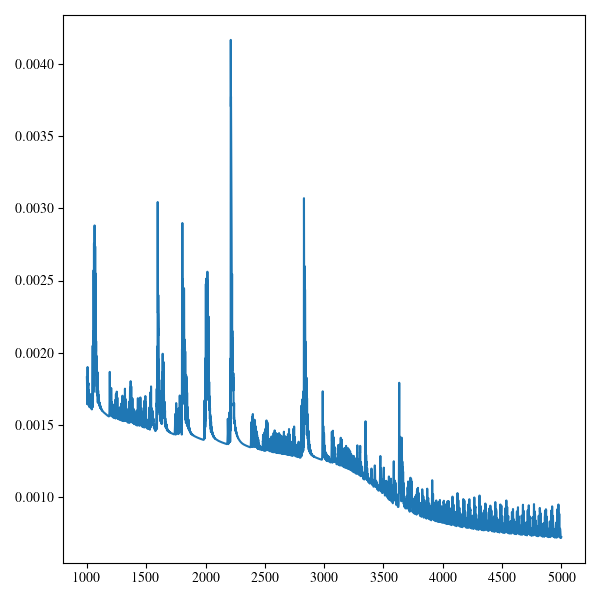

In [7]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

init_epoch = 1000
ax.plot(loss[init_epoch:,0], loss[init_epoch:,2])

# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_loss_second.png', format='png', dpi=300, bbox_inches="tight")

## Plot

In [8]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
grid_vr = torch.zeros_like(grid_xr).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [9]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

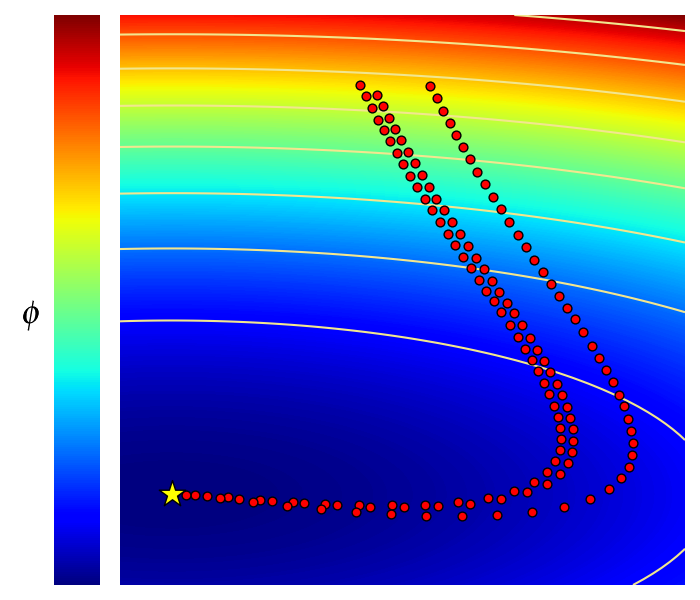

In [10]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_potential_second.png', format='png', dpi=300, bbox_inches="tight")

### Vector Field & Streamlines

In [11]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
phi = KernelDeformation(obstacle.to(device), weights = 10.0*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
# embedding.local_deformation = phi


field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

# # x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), length=0.01, samples=3).to(device).requires_grad_(True)
# x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), la=0.1, lb=0.01, samples=5).to(device).requires_grad_(True)
# v0 = torch.zeros_like(x0).to(device).requires_grad_(True)
# streamlines = Integrator.second_order(dynamics=model,x0=torch.cat((x0,v0),dim=1),T=6.5, dt=0.01).cpu().detach().numpy()

x0 = np.empty((0, 4))
for i in range(1, num_traj + 1):
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    data[:,:2] -= data[-1,:2]
    x0 = np.append(x0, data[0,:4][np.newaxis, :], axis=0)
x0 = torch.from_numpy(x0).float().to(device).requires_grad_(True)
streamlines = Integrator.second_order(dynamics=model,x0=x0,T=10.0, dt=0.01).cpu().detach().numpy()

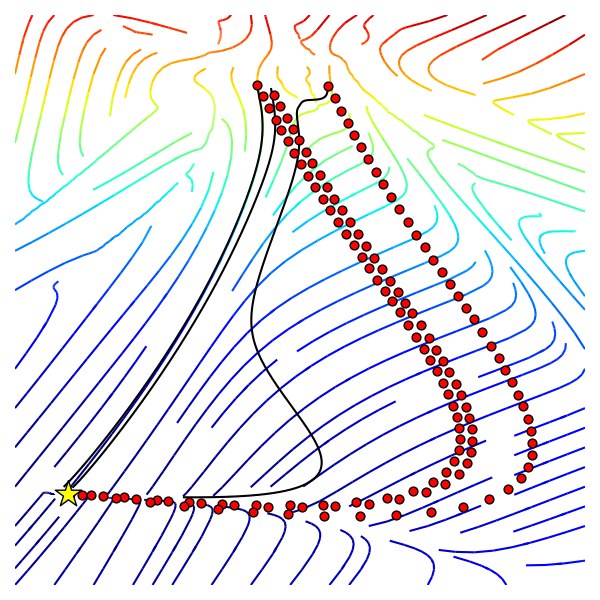

In [12]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=1.5)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="8%", pad=0.2)
# cax.yaxis.set_label_position("right")
# norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
# colors = plt.cm.jet(norm(potential))
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, cax=cax)
# cbar.outline.set_visible(False)
# cbar.ax.tick_params(size=0)
# cbar.set_ticks([])
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=20)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_field_second.png', format='png', dpi=300, bbox_inches="tight")

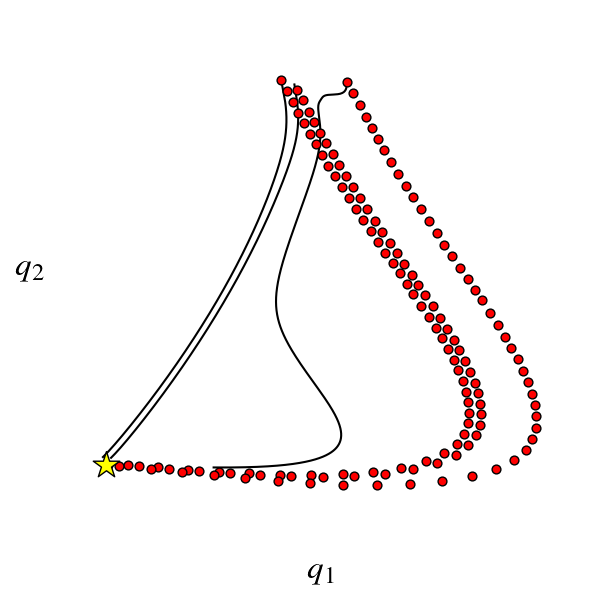

In [13]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=1.5)

ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel(r'$q_1$', fontsize=24)
ax.set_ylabel(r'$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_streamlines_second.png', format='png', dpi=300, bbox_inches="tight")

In [14]:
streamlines.shape

(1000, 3, 4)

### Embedding

In [15]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x[:,:dim]).cpu().detach().numpy()

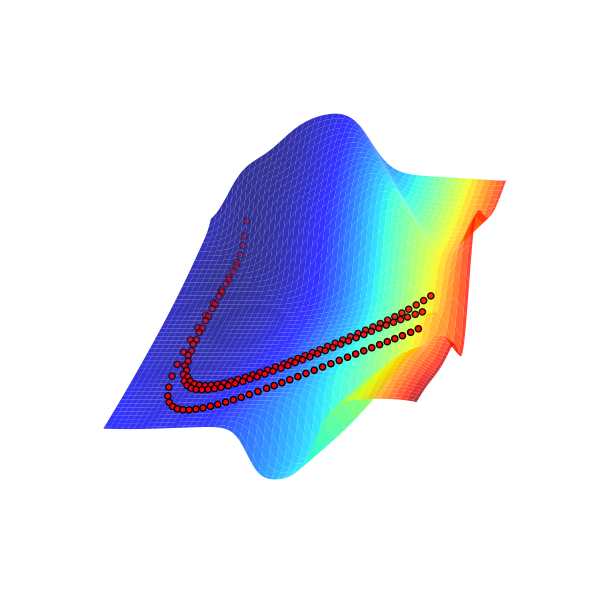

In [16]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

steps = 20
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))

im = ax.plot_surface(x_embedding, y_embedding, z_embedding, cmap='jet', edgecolor='none', antialiased=True, alpha=0.8, facecolors=colors)
ax.scatter(train_embedding[::steps, 0], train_embedding[::steps, 1], train_embedding[::steps, 2], s=20, edgecolors='k', c='red', zorder=10)

ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')

# Adjust plot limits, if necessary
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

ax.axis('off')

ax.view_init(elev=30, azim=18)  # Adjust the elevation (up/down) and azimuth (left/right) an

# # Add colorbar without ticks and labels
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)

# cbar.ax.set_yticklabels([])
# cbar.ax.tick_params(length=0)
# cbar.outline.set_visible(False)  # Remove colorbar frame

# # Shrink colorbar to dimensions of the plot
# cbar.ax.set_position([0.52, 0.1, 0.03, 0.8])  # Adjust colorbar position and width

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_embedding_second.png', format='png', dpi=300, bbox_inches="tight")

### Metric

In [17]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)
evals /= torch.tensor([100,10000]).to(device)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

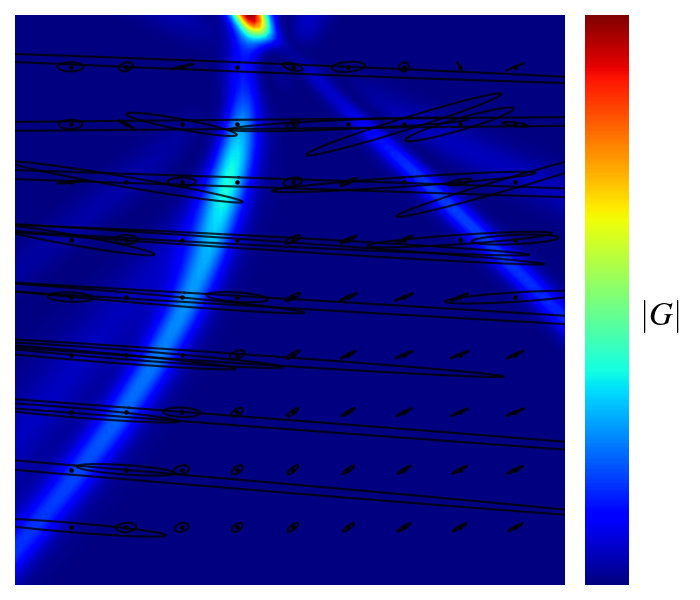

In [18]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the filled contour
contour = ax.contourf(x, y, det_metric, 500, cmap="jet")

# Plot scattered points
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)

# Plot ellipses
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label(r'$|G|$', fontsize=24, rotation=0, labelpad=25)

# Set labels and tick sizes
# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_detmetric_second.png', format='png', dpi=300, bbox_inches="tight")

### Inverse Metric Ellispses on Streamlines

In [19]:
eval_scale = 10
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_evals/= torch.tensor([100,100]).to(device)

metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

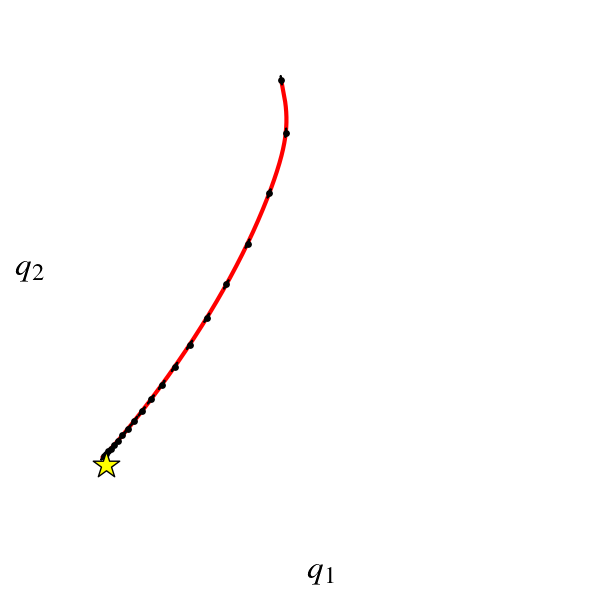

In [20]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_metric_second.png', format='png', dpi=300, bbox_inches="tight")

### Christoffel Symbols Ellispses on Streamlines

In [21]:
christoffel_sampled = embedding.christoffel(x_sampled, metric_sampled)
christoffel_sampled = torch.einsum('bqij,bi->bqj', christoffel_sampled, v_sampled)
christoffel_evals,christoffel_evecs = torch.linalg.eig(christoffel_sampled)
christoffel_evals = torch.real(christoffel_evals)
christoffel_evecs = torch.real(christoffel_evecs)
christoffel_evals/= torch.tensor([20,0.000001]).to(device)

christoffel_ellipses = torch.stack((christoffel_evals[:, 0].unsqueeze(-1)*theta.cos(), christoffel_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
christoffel_ellipses = torch.bmm(christoffel_evecs, christoffel_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

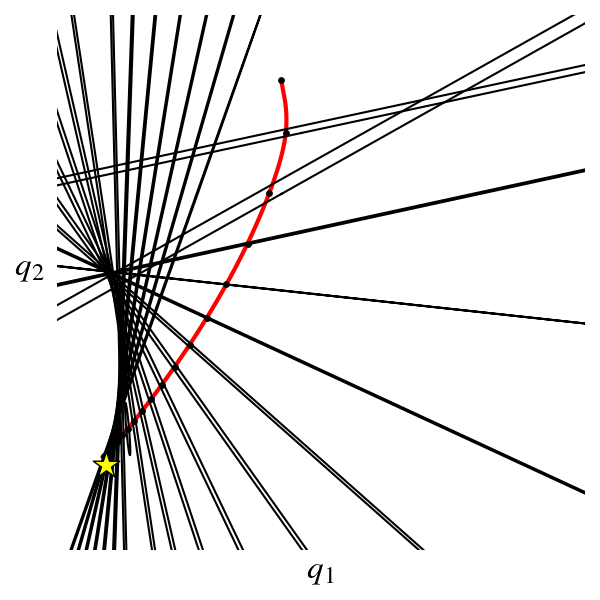

In [22]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0,christoffel_ellipses.shape[0],step):
    ax.plot(x_sampled[i, 0].detach().cpu() + christoffel_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + christoffel_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
        
# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_christoffel_second.png', format='png', dpi=300, bbox_inches="tight")